<a href="https://colab.research.google.com/github/QaziSaim/Fine-Tune-Projects/blob/main/Bahdanau_Attention_Mechenisum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Luckly I already had saved my tokenizer now i am going to load it

In [1]:
import numpy as np
import pandas as pd
import tensorflow
import re
import string
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Layer
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('https://github.com/QaziSaim/Fine-Tune-Projects/raw/refs/heads/main/Encoder-Decoder-Machine-Translation/eng_to_fra.csv')

In [3]:
df = df.iloc[:15000]

In [4]:
df.shape

(15000, 2)

In [5]:
df.isnull().sum()

,0
eng_texts,0
fra_texts,0


In [6]:
eng_tokenizer = Tokenizer(filters='',lower=True,oov_token='<oov>')
eng_tokenizer.fit_on_texts(df.eng_texts)
eng_sequence = eng_tokenizer.texts_to_sequences(df.eng_texts)

In [7]:
fra_tokenizer = Tokenizer(filters='',lower=True,oov_token='<oov>')
fra_tokenizer.fit_on_texts(df.fra_texts)
fra_sequence = fra_tokenizer.texts_to_sequences(df.fra_texts)

In [8]:
eng_vocab_size = len(eng_tokenizer.word_index) +1
fra_vocab_size = len(fra_tokenizer.word_index) + 1


In [9]:
max_eng_len = max(len(x) for x in eng_sequence)
max_fra_len = max(len(x) for x in fra_sequence)

In [10]:
encoder_input = pad_sequences(eng_sequence, maxlen=max_eng_len, padding='post')
decoder_input = pad_sequences([s[:-1] for s in fra_sequence],maxlen=max_fra_len-1,padding='post')
decoder_target = pad_sequences([s[1:] for s in fra_sequence],maxlen=max_fra_len-1,padding='post')

In [11]:
X_train_enc, X_val_enc, X_train_dec, X_val_dec, y_train, y_val = train_test_split(
    encoder_input, decoder_input, decoder_target, test_size=0.1, random_state=42
)

In [12]:
vocab_input_size = len(eng_tokenizer.word_index) + 1
vocab_target_size = len(fra_tokenizer.word_index) + 1

In [13]:
embedding_dim = 128
units = 256
batch = 16
EPOCHES = 50

In [14]:
# tensorflow.config.run_functions_eagerly(True)

In [15]:
class BahdanauAttetion(Layer):
  def __init__(self,units):
    super().__init__()
    self.w1 =  Dense(units)
    self.w2 = Dense(units)
    self.V = Dense(1)

  def call(self,query,value):
    query_with_time_axis = tensorflow.expand_dims(query, 1)
    score = self.V(tensorflow.nn.tanh(self.w1(value) + self.w2(query_with_time_axis)))
    attention_weights = tensorflow.nn.softmax(score, axis=1)
    context_vector = tensorflow.reduce_sum(attention_weights * value, axis=1)
    return context_vector, tensorflow.squeeze(attention_weights, -1)


In [16]:
from tensorflow.keras.saving import register_keras_serializable

@register_keras_serializable(package="CustomModels")

class Encoder(Model):
  def __init__(self, vocab_size, embedding_dim, enc_units):
    super().__init__()
    self.enc_units = enc_units
    self.embedding = Embedding(vocab_size,embedding_dim)
    self.lstm = LSTM(enc_units, return_sequences=True, return_state=True)

  def call(self, x):
    x = self.embedding(x)
    output, state_h, state_c = self.lstm(x)
    return output, state_h, state_c


In [17]:
@register_keras_serializable(package="CustomModels")
class Decoder(Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super().__init__()
        self.dec_units = dec_units
        self.embedding = Embedding(vocab_size, embedding_dim)
        self.attention = BahdanauAttetion(dec_units)   # keep your attention class name
        self.cell = tensorflow.keras.layers.LSTMCell(dec_units)
        self.fc = Dense(vocab_size)

    def call(self, dec_input, enc_output, initial_state):
        """
        dec_input: (batch, dec_seq_len)  -- teacher forcing input during training or single-step during inference
        enc_output: (batch, enc_seq_len, enc_units)
        initial_state: tuple (h, c)  each (batch, dec_units)
        Returns:
            logits_seq: (batch, dec_seq_len, vocab_size)
            states: tuple (h, c)
            attention_history: (batch, dec_seq_len, enc_seq_len)
        """
        # embeddings -> (batch, dec_seq_len, emb_dim)
        embeddings = self.embedding(dec_input)

        # dynamic lengths (tensors)
        dec_seq_len = tensorflow.shape(dec_input)[1]

        # prepare TensorArrays for outputs & attention history (write per timestep)
        outputs_ta = tensorflow.TensorArray(dtype=tensorflow.float32, size=0, dynamic_size=True)
        attn_ta = tensorflow.TensorArray(dtype=tensorflow.float32, size=0, dynamic_size=True)

        # ensure initial_state is a tuple (h, c)
        init_h, init_c = initial_state
        # Use a LIST for states inside while_loop to keep structure stable across iterations
        states_list = [init_h, init_c]

        # step function for tf.while_loop
        def step(t, states_list, outputs_ta, attn_ta):
            # states_list is a list [h, c]
            h = states_list[0]
            c = states_list[1]

            # get t-th embedding: (batch, emb_dim)
            x_t = embeddings[:, t, :]

            # compute attention using current hidden state h
            context_vector, attn_weight = self.attention(h, enc_output)  # context: (batch, dec_units), attn_weight: (batch, enc_seq_len)

            # concat input & context -> (batch, emb_dim + dec_units)
            x_and_context = tensorflow.concat([x_t, context_vector], axis=-1)

            # LSTMCell expects a tuple of states
            output, new_states = self.cell(x_and_context, (h, c))
            new_h, new_c = new_states

            # project to vocabulary logits
            logits = self.fc(output)  # (batch, vocab_size)

            # write logits & attention to TensorArrays (indexed by timestep)
            outputs_ta = outputs_ta.write(t, logits)
            attn_ta = attn_ta.write(t, attn_weight)

            # pack new states as list for the next iteration
            new_states_list = [new_h, new_c]

            return t + 1, new_states_list, outputs_ta, attn_ta

        # while loop condition
        t0 = tensorflow.constant(0)
        cond = lambda t, *_: t < dec_seq_len

        # run the loop
        _, final_states_list, outputs_ta, attn_ta = tensorflow.while_loop(
            cond,
            step,
            loop_vars=[t0, states_list, outputs_ta, attn_ta],
            shape_invariants=[
                t0.get_shape(),
                [tensorflow.TensorShape([None, self.dec_units]), tensorflow.TensorShape([None, self.dec_units])],
                tensorflow.TensorShape(None),
                tensorflow.TensorShape(None),
            ]
        )

        # stack results: outputs_ta.stack() -> (dec_seq_len, batch, vocab)
        logits_stacked = outputs_ta.stack()
        attn_stacked = attn_ta.stack()

        # transpose to (batch, dec_seq_len, ...)
        logits_seq = tensorflow.transpose(logits_stacked, perm=[1, 0, 2])
        attention_history = tensorflow.transpose(attn_stacked, perm=[1, 0, 2])

        # convert final states back to tuple (h, c)
        final_h = final_states_list[0]
        final_c = final_states_list[1]
        final_states = (final_h, final_c)

        return logits_seq, final_states, attention_history


In [18]:
class Seq2Seq(Model):
  def __init__(self, encoder,decoder):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    enc_in, dec_in = inputs

    enc_output,enc_h,enc_c = self.encoder(enc_in)
    logits, _, attn = self.decoder(dec_in, enc_output, (enc_h, enc_c))
    return logits


In [19]:
encoder = Encoder(vocab_input_size, embedding_dim, units)
decoder = Decoder(vocab_target_size, embedding_dim, units)
model = Seq2Seq(encoder,decoder)

In [20]:
loss_object = tensorflow.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [21]:
def loss_function(real, pred):
  mask = tensorflow.cast(tensorflow.not_equal(real, 0), dtype=tensorflow.float32)
  loss_ = loss_object(real, pred)
  loss_ *= mask
  return tensorflow.reduce_sum(loss_) / (tensorflow.reduce_sum(mask) + 1e-9)

In [22]:
model.compile(optimizer='adam',loss=loss_function, metrics=['accuracy'])

In [23]:
encoder_input = np.array(encoder_input)
decoder_input = np.array(decoder_input)
decoder_target = np.array(decoder_target)

In [24]:
model.summary()

Model: "seq2_seq"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Encoder)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Decoder)               │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [25]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss',restore_best_weights=True, patience=5)

In [26]:
# model.fit([encoder_input, decoder_input],decoder_target,batch_size=batch,epochs=EPOCHES)
history = model.fit([X_train_enc, X_train_dec], y_train, validation_data=([X_val_enc, X_val_dec], y_val),batch_size = batch, epochs=EPOCHES,callbacks=[es])

Epoch 1/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 46s 43ms/step - accuracy: 0.0994 - loss: 5.4655 - val_accuracy: 0.1310 - val_loss: 4.2878
Epoch 2/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.1404 - loss: 3.8902 - val_accuracy: 0.1581 - val_loss: 3.7333
Epoch 3/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 36s 43ms/step - accuracy: 0.1666 - loss: 3.1999 - val_accuracy: 0.1727 - val_loss: 3.4303
Epoch 4/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 36s 42ms/step - accuracy: 0.1834 - loss: 2.7204 - val_accuracy: 0.1828 - val_loss: 3.2687
Epoch 5/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 36s 42ms/step - accuracy: 0.1963 - loss: 2.3579 - val_accuracy: 0.1897 - val_loss: 3.1411
Epoch 6/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 37s 44ms/step - accuracy: 0.2069 - loss: 2.0343 - val_accuracy: 0.1951 - val_loss: 3.0327
Epoch 7/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 36s 42ms/step - accuracy: 0.2198 - loss: 1.7794 - val_accuracy: 0.1989 - val_loss: 2.9846
Epoch 8/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 36s 42ms/step - accuracy: 0.2324 - loss: 1.5455 - 

In [28]:
model.summary()

Model: "seq2_seq"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Encoder)               │ ?                      │       763,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Decoder)               │ ?                      │     3,107,080 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,610,650 (44.29 MB)

 Trainable params: 3,870,216 (14.76 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,740,434 (29.53 MB)

In [29]:
val_loss, val_acc = model.evaluate([X_val_enc, X_val_dec], y_val)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.2198 - loss: 2.8225
Validation Loss: 2.8976, Validation Accuracy: 0.2154


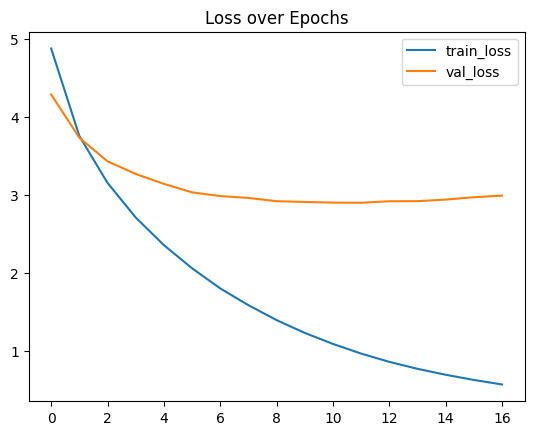

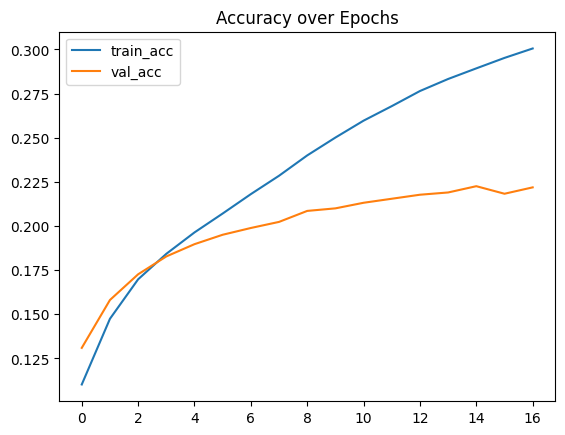

In [30]:
# history = model.fit([...])

import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()


In [31]:
def translate(sentence):
  seq = eng_tokenizer.texts_to_sequences([sentence.lower()])
  seq = pad_sequences(seq, maxlen = max_eng_len,padding='post')
  enc_output, enc_h, enc_c = encoder(seq)
  states = (enc_h, enc_c)

  start_id = fra_tokenizer.word_index.get('<start>')
  end_id  = fra_tokenizer.word_index.get('<end>')
  dec_input_id = np.array([[start_id]])

  result_token = []

  for _ in range(max_fra_len):
    logits_seq, states, attn = decoder(dec_input_id, enc_output, states)

    pred_id = tensorflow.argmax(logits_seq[:, -1, :], axis = 1).numpy()[0]

    if pred_id == 0:
      break
    if pred_id == end_id:
      break
    result_token.append(pred_id)
    dec_input_id = np.array([[pred_id]])


  inv_map = {v:k for k,v in fra_tokenizer.word_index.items()}
  words = [inv_map.get(i, '') for i in result_token]

  return ' '.join(words)

In [32]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# --- Utility: map id → word
index_to_word = {v: k for k, v in fra_tokenizer.word_index.items()}

def translate(sentence, max_dec_len=None):
    if max_dec_len is None:
        max_dec_len = decoder_input.shape[1]

    # 1️⃣ Tokenize & pad English sentence
    seq = eng_tokenizer.texts_to_sequences([sentence.lower()])
    seq = pad_sequences(seq, maxlen=encoder_input.shape[1], padding='post')

    # 2️⃣ Encode input
    enc_output, h, c = encoder(seq)

    # 3️⃣ Initialize decoder with <start> token
    start_id = fra_tokenizer.word_index.get('<start>', 1)
    end_id = fra_tokenizer.word_index.get('<end>', 2)
    dec_input = np.array([[start_id]])
    states = (h, c)

    # 4️⃣ Greedy decoding loop
    result_ids = []
    for _ in range(max_dec_len):
        # Forward pass through decoder
        logits, states, _ = decoder(dec_input, enc_output, states)
        # Pick highest-probability token
        pred_id = int(tensorflow.argmax(logits[:, -1, :], axis=-1).numpy()[0])

        # Stop if <end>
        if pred_id == end_id or pred_id == 0:
            break

        result_ids.append(pred_id)
        # Next decoder input is current prediction
        dec_input = np.array([[pred_id]])

    # 5️⃣ Convert ids → words
    words = [index_to_word.get(i, '') for i in result_ids]
    translation = ' '.join(words)
    return translation.strip()

# Example usage
print("My name is english")
print("French :", translate("i hate you"))

print("\nEnglish: how are you")
print("French :", translate("how are you"))


My name is english
French : je me suis fait

English: how are you
French : comment vastu


In [33]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

smooth = SmoothingFunction().method1
total_bleu = 0
n_samples = 100  # evaluate on subset

for i in range(n_samples):
    eng_sentence = df.eng_texts.iloc[i]
    true_fra = df.fra_texts.iloc[i].replace("<start>", "").replace("<end>", "").strip()
    pred_fra = translate(eng_sentence)

    reference = [true_fra.split()]
    candidate = pred_fra.split()
    total_bleu += sentence_bleu(reference, candidate, smoothing_function=smooth)

avg_bleu = total_bleu / n_samples
print(f"Average BLEU score on {n_samples} samples: {avg_bleu:.4f}")


Average BLEU score on 100 samples: 0.1122


### Saving Models

In [36]:
import os, json, pickle, tensorflow as tf

# Directory to save everything
os.makedirs("translation_model", exist_ok=True)

# 1️⃣ Save full seq2seq model (for quick re-use)
model.save("translation_model/full_seq2seq_model.keras",save_format='keras')

# 2️⃣ Save encoder and decoder separately (for inference)
encoder.save("translation_model/encoder.keras",save_format='keras')
decoder.save("translation_model/decoder.keras",save_format='keras')

# 3️⃣ Save tokenizers
with open("translation_model/eng_tokenizer.pkl", "wb") as f:
    pickle.dump(eng_tokenizer, f)

with open("translation_model/fra_tokenizer.pkl", "wb") as f:
    pickle.dump(fra_tokenizer, f)

# 4️⃣ Save config JSON (hyper-parameters)
config = {
    "embedding_dim": embedding_dim,
    "units": units,
    "max_eng_len": int(max_eng_len),
    "max_fra_len": int(max_fra_len),
    "vocab_input_size": vocab_input_size,
    "vocab_target_size": vocab_target_size
}

with open("translation_model/config.json", "w") as f:
    json.dump(config, f, indent=4)

print("✅ All model files saved in ./translation_model/")


✅ All model files saved in ./translation_model/


In [35]:
import shutil
import os

# Replace 'my_folder' with the actual name of your folder in Colab
folder_to_zip = 'translation_model'
zip_filename = f'{folder_to_zip}.zip'

# Create the zip archive
shutil.make_archive(folder_to_zip, 'zip', folder_to_zip)

'/content/translation_model.zip'